# Assignment 1: CRF sequence tagging for Movie Queries

This coursework involves optimizing the performance of a **Conditional Random Field (CRF) sequence tagger** for movie trivia questions and answers data, which consist of instances of data of word sequences with the target classes/labels for each word in a **BIO (Beginning, Inside, Outside)** tagging format. 

This assignment involves reading in, pre-processing, training and developing your tagger on the training data from *trivia10k13train.bio.txt*, and finally testing your tagger on the data *trivia10k13test.bio.txt*, attempting to get the best performing tagger across the different labels in your development process. Parts of these steps have been done for you already. You are going to optimize the performance of the tagger by improving its feature extraction function on the word sequences, incorporating POS tagging first, then the final exercise is to optimize the performance by all legal means neccessary (except looking at the test data). Run and follow the code below and then attempt the questions.

**NOTEBOOK/CODE SUBMISSION: PLEASE SUBMIT IN NOTEBOOK FORM IF YOU CAN RATHER THAN IN A PYTHON FILE, MAKING YOUR CODE ADDITIONS TO THIS TEMPLATE FILE. SUBMISSION MUST BE IN PYTHON 3.7+ AND YOU MUST HAVE RUN THE CODE RUNNING FROM TOP TO BOTTOM BEFORE SUBMISSION.**

**WRITTEN REPORT SUBMISSION: YOU MUST INCLUDE A 2-PAGE MAX LENGTH REPORT SUMMARIZING HOW YOU WENT ABOUT ACHIEVING EACH QUESTION, TO BE SUBMITTED WITH YOUR CODE. PLEASE WRITE SUCCINCTLY AND CLEARLY, IN THE STYLE OF A SCIENTIFIC NLP CONFERENCE PAPER. AUTOMATIC PLAGIARISM DETECTION WILL BE RUN ON THESE FILES.**

In [1]:
# You may need to run this first- uncomment if so
#!pip install python-crfsuite

In [128]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [3]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    B-Actor	steve
    I-Actor	mcqueen
    O	provided
    O	a
    B-Plot	thrilling
    I-Plot	motorcycle
    I-Plot	chase
    I-Plot	in
    I-Plot	this
    B-Opinion	greatest
    I-Opinion	of
    I-Opinion	all
    B-Plot	ww
    I-Plot	2
    I-Plot	prison
    I-Plot	escape
    I-Plot	movies
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [4]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [5]:
# have a look at the first example
print(raw_training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [6]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

7816 instances
158823 words


In [7]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [8]:
training_data = [preProcess(example) for example in raw_training_data]

In [9]:
# check the effect of pre-processing
print(training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [10]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [28]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
#ct.train(training_data, TAGGER_PATH)
ct.train(new_train, TAGGER_PATH)
print("done")

training tagger...
done


In [12]:
# let's see how it does in testing on sentences
def print_tags(sentence):
    # a method to print out the sequence with its tags
    tokens = sentence.split()
    tags = [p[1] for p in ct.tag(tokens)]
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')

In [13]:
# an example from the corpus
example = "steve mcqueen provided a thrilling motorcycle chase in this greatest of all ww 2 prison escape movies"
print_tags(example)

steve       B-Actor
mcqueen     I-Actor
provided    O
a           B-Plot
thrilling   I-Plot
motorcycle  I-Plot
chase       I-Plot
in          I-Plot
this        I-Plot
greatest    I-Plot
of          I-Plot
all         I-Plot
ww          I-Plot
2           I-Plot
prison      I-Plot
escape      I-Plot
movies      I-Plot


In [14]:
# a novel, unseen example we've just made up
print_tags("batman is the main character in batman begins")

batman      O
is          O
the         O
main        O
character   O
in          O
batman      B-Character_Name
begins      I-Character_Name


In [15]:
# another example
print_tags("the sound of music")

the         O
sound       O
of          O
music       O


In [16]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1953 instances
39035 words


In [29]:
print("testing tagger...")
preds = []
y_test = []
#for sent in test_data:
for sent in new_test:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [18]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

/Users/ishaanchaturvedi/opt/anaconda3/envs/netx/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ishaanchaturvedi/opt/anaconda3/envs/netx/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.85      0.88      0.87      1274
         B-Award       0.72      0.62      0.67        66
B-Character_Name       0.78      0.24      0.37       283
      B-Director       0.84      0.72      0.78       425
         B-Genre       0.83      0.76      0.80       789
       B-Opinion       0.49      0.30      0.37       195
        B-Origin       0.52      0.38      0.44       190
          B-Plot       0.49      0.47      0.48      1577
         B-Quote       0.75      0.26      0.38        47
  B-Relationship       0.80      0.53      0.64       171
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.94      0.97      0.96       661
         I-Actor       0.86      0.89      0.87      1553
         I-Award       0.74      0.69      0.72       147
I-Character_Name       0.82      0.30      0.43       227
      I-Director       0.89      0.74      0.81       411
         I-Ge

/Users/ishaanchaturvedi/opt/anaconda3/envs/netx/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ishaanchaturvedi/opt/anaconda3/envs/netx/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels = labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

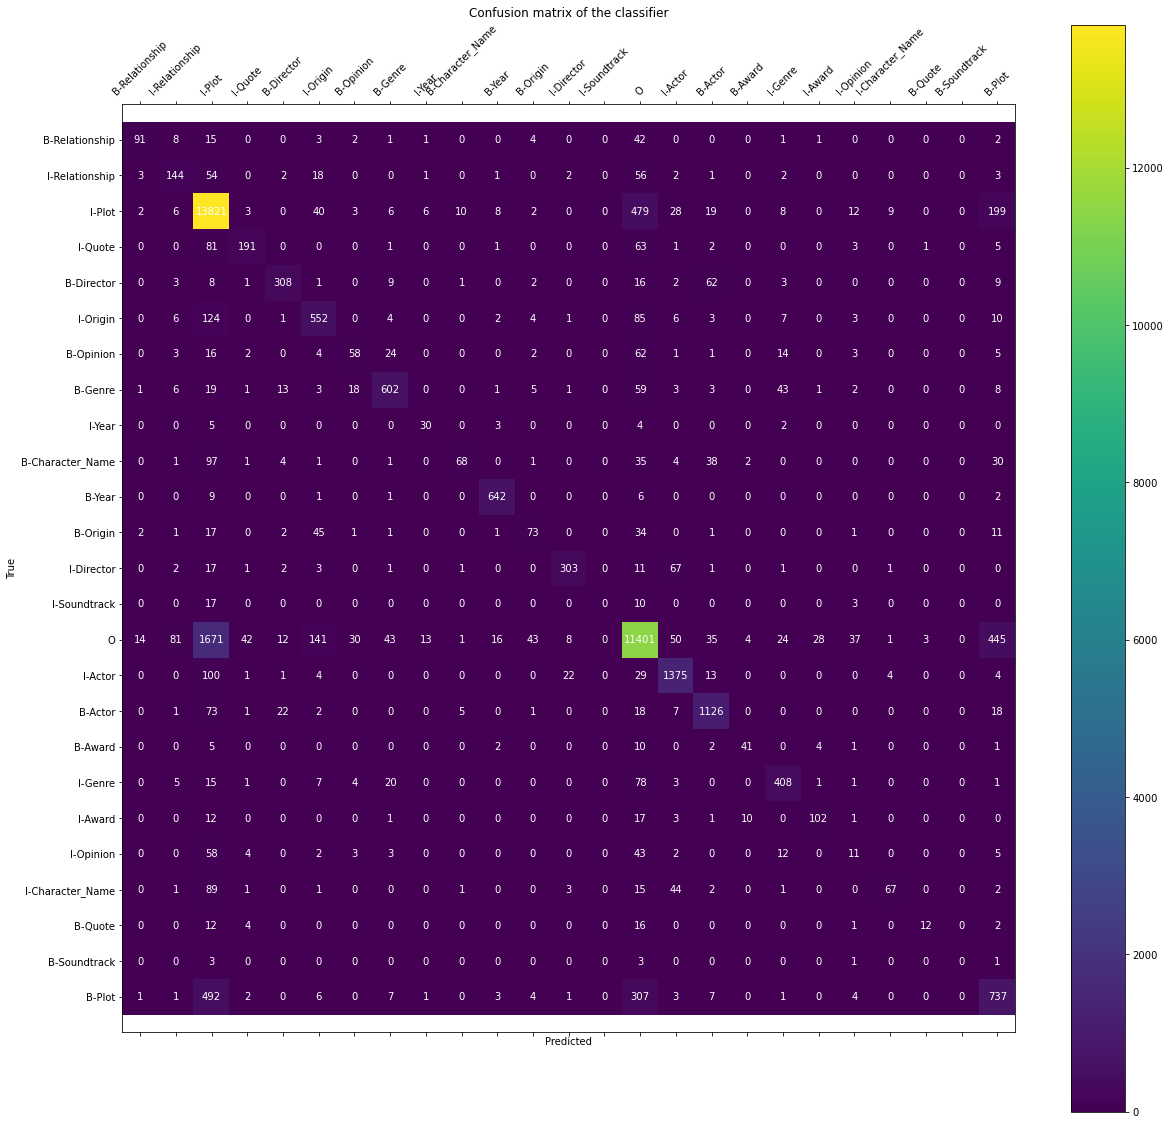

In [22]:
confusion_matrix_heatmap(y_test, preds)

In [21]:
# Let's see what the CRF learned by looking at the internal transition/feature weights....

In [23]:
def print_transition_weights(transitions):
    """Sort the transitions between states/labels from highest to
    lowest strengths and print out."""
    ranked_transitions = [x for x in sorted(transitions,
                                               key=lambda x:x[1], reverse=True)]
    for (label_from, label_to), weight in ranked_transitions:
        print("%0.6f %-8s -> %s" % (weight, label_from, label_to))

In [24]:
print_transition_weights(ct._tagger.info().transitions.items())

8.730936 B-Actor  -> I-Actor
8.345982 B-Plot   -> I-Plot
8.062881 B-Director -> I-Director
7.851024 B-Origin -> I-Origin
7.728286 I-Plot   -> I-Plot
7.557302 I-Quote  -> I-Quote
7.400516 B-Character_Name -> I-Character_Name
7.347592 I-Origin -> I-Origin
7.270472 B-Relationship -> I-Relationship
7.168646 B-Quote  -> I-Quote
7.019230 I-Relationship -> I-Relationship
6.874782 I-Soundtrack -> I-Soundtrack
6.792831 I-Opinion -> I-Opinion
6.739054 B-Genre  -> I-Genre
6.682199 B-Soundtrack -> I-Soundtrack
6.580473 B-Award  -> I-Award
6.441732 B-Opinion -> I-Opinion
6.428294 I-Award  -> I-Award
6.362482 I-Genre  -> I-Genre
6.348037 I-Actor  -> I-Actor
6.225893 I-Character_Name -> I-Character_Name
5.430455 I-Director -> I-Director
4.809019 I-Year   -> I-Year
4.082752 B-Year   -> I-Year
3.773733 B-Character_Name -> B-Plot
3.563915 O        -> O
3.562699 I-Character_Name -> B-Plot
3.277145 O        -> B-Plot
3.199695 B-Plot   -> B-Character_Name
3.091597 B-Opinion -> B-Genre
3.030532 O        -> 

In [25]:
def print_most_predictive_state_features(state_features,
                                         excluded_classes=["O"],
                                         top_k=None):
    """Takes in the dict of state_features from a python crf-suite tagger,
    orders them in terms of how predictive they are of different classes.
    We assume we are not interested in O labels."""
    if not top_k:
        top_k = len(state_features)  # assume we want to print all of them
    ranked_state_features = [x for x in sorted(state_features, key=lambda x:x[1], reverse=True) \
         if x[0][1] not in excluded_classes][:top_k]
    for (attr, label), weight in ranked_state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

In [26]:
print_most_predictive_state_features(ct._tagger.info().state_features.items())

5.191234 B-Year   HAS_NUM
4.378852 B-Genre  WORD_animated
4.376891 I-Year   WORD_s
3.280298 B-Genre  WORD_thriller
2.998992 B-Quote  WORD_i
2.986864 I-Genre  WORD_animated
2.968166 B-Genre  WORD_action
2.913375 B-Plot   WORD_a
2.910979 B-Opinion WORD_blockbuster
2.682290 B-Award  WORD_oscar
2.667863 B-Genre  WORD_animation
2.596255 B-Relationship SUF_uel
2.572959 B-Director WORD_disney
2.563763 B-Opinion WORD_masterpiece
2.552841 I-Genre  WORD_fiction
2.542230 B-Award  SUF_car
2.527780 B-Relationship WORD_remake
2.471652 B-Actor  WORD_cher
2.439679 B-Genre  WORD_horror
2.427487 I-Genre  WORD_white
2.413953 B-Relationship WORD_sequel
2.410295 I-Genre  WORD_thriller
2.378248 B-Genre  WORD_slasher
2.370675 B-Genre  WORD_comedy
2.337885 B-Origin WORD_adapted
2.304871 I-Actor  WORD_cage
2.276711 B-Genre  WORD_documentary
2.231418 B-Director SUF_xar
2.231418 B-Director WORD_pixar
2.227497 B-Genre  WORD_romance
2.184817 B-Genre  WORD_war
2.180846 B-Award  WORD_won
2.177721 B-Plot   WORD_an
2.

0.633577 B-Actor  SUF_zel
0.633555 I-Plot   WORD_like
0.633344 I-Plot   WORD_tracking
0.633215 I-Actor  SUF_ek
0.633212 B-Actor  SUF_enn
0.633122 B-Origin SUF_ter
0.633006 B-Actor  WORD_christina
0.632698 I-Origin SUF_rue
0.632698 I-Origin WORD_true
0.632164 I-Plot   WORD_car
0.632121 I-Plot   WORD_pumpkin
0.632054 I-Director WORD_aronofsky
0.632032 I-Origin WORD_dahl
0.631943 B-Character_Name WORD_merlin
0.631793 I-Actor  WORD_damme
0.631582 I-Plot   WORD_money
0.631580 I-Character_Name SUF_hur
0.631454 I-Actor  WORD_van
0.631347 I-Origin SUF_oon
0.631100 I-Director SUF_mi
0.630791 B-Director WORD_darren
0.630723 B-Opinion WORD_highly
0.630524 I-Director WORD_disney
0.630512 I-Actor  WORD_ford
0.629843 I-Plot   SUF_oth
0.629826 B-Plot   WORD_father
0.629772 B-Actor  SUF_ert
0.629737 B-Genre  SUF_ick
0.629487 I-Plot   WORD_murdered
0.629447 B-Quote  WORD_you
0.629434 I-Plot   WORD_saved
0.629376 B-Actor  WORD_haley
0.629358 I-Origin SUF_ast
0.629279 I-Award  SUF_f
0.629206 B-Origin SUF

0.438596 B-Character_Name WORD_sneezy
0.438531 B-Origin WORD_annie
0.438488 B-Opinion WORD_pivotal
0.438424 I-Actor  SUF_uf
0.438368 B-Soundtrack SUF_tin
0.438330 I-Plot   WORD_blow
0.438307 B-Opinion WORD_tear
0.438302 I-Director SUF_owe
0.438285 I-Relationship WORD_letter
0.438239 B-Actor  WORD_willis
0.438159 I-Director SUF_rry
0.438159 I-Opinion WORD_raved
0.438154 I-Quote  SUF_ou
0.438119 B-Director WORD_afred
0.438118 I-Quote  SUF_od
0.438070 I-Character_Name WORD_fredrickson
0.437973 B-Plot   SUF_age
0.437964 B-Plot   SUF_nam
0.437964 B-Plot   WORD_vietnam
0.437958 B-Character_Name SUF_hon
0.437938 B-Plot   WORD_loner
0.437914 I-Origin SUF_deo
0.437914 I-Origin WORD_video
0.437903 B-Plot   WORD_japanese
0.437903 B-Plot   WORD_clarice
0.437892 B-Character_Name SUF_aug
0.437892 B-Character_Name WORD_smaug
0.437845 I-Genre  WORD_v
0.437825 B-Character_Name WORD_steven
0.437821 B-Year   SUF_64
0.437821 B-Year   SUF_964
0.437821 B-Year   WORD_1964
0.437799 I-Plot   WORD_redemption
0.

0.348023 B-Plot   WORD_morrocco
0.347858 B-Plot   WORD_football
0.347815 B-Plot   SUF_use
0.347788 B-Year   WORD_70
0.347784 B-Relationship WORD_famous
0.347764 B-Relationship SUF_act
0.347633 I-Character_Name WORD_stern
0.347601 I-Quote  WORD_home
0.347583 I-Award  SUF_ute
0.347578 I-Plot   WORD_joads
0.347518 I-Character_Name SUF_rty
0.347484 B-Year   SUF_85
0.347484 B-Year   SUF_985
0.347484 B-Year   WORD_1985
0.347440 I-Plot   WORD_deaths
0.347432 B-Character_Name SUF_ven
0.347424 I-Origin WORD_cinderella
0.347417 I-Plot   SUF_ech
0.347406 B-Character_Name SUF_hak
0.347406 B-Character_Name WORD_itzhak
0.347313 I-Plot   WORD_murders
0.347160 B-Actor  WORD_hal
0.347152 I-Character_Name SUF_het
0.347126 B-Character_Name WORD_gay
0.347110 I-Plot   WORD_league
0.347071 B-Actor  SUF_ebe
0.347064 I-Actor  WORD_gandolfini
0.347057 B-Actor  WORD_eli
0.347055 I-Actor  WORD_coddry
0.346931 I-Relationship WORD_hop
0.346929 B-Plot   SUF_or
0.346847 B-Soundtrack SUF_ime
0.346760 B-Plot   SUF_its

0.266655 B-Character_Name SUF_nn
0.266634 I-Plot   WORD_avenging
0.266585 I-Actor  SUF_ths
0.266568 I-Relationship SUF_un
0.266559 I-Actor  SUF_shi
0.266554 I-Director WORD_terentino
0.266493 B-Director SUF_gei
0.266493 B-Director WORD_sergei
0.266465 B-Plot   WORD_strict
0.266429 B-Plot   SUF_ly
0.266405 I-Plot   SUF_ask
0.266391 B-Soundtrack SUF_ous
0.266366 I-Plot   SUF_led
0.266313 I-Plot   WORD_harrasses
0.266177 I-Plot   WORD_indians
0.266150 B-Director WORD_rene
0.266149 B-Director WORD_carl
0.266133 I-Origin SUF_06
0.266133 I-Origin SUF_006
0.266133 I-Origin WORD_2006
0.266131 I-Origin WORD_h
0.266049 B-Plot   SUF_ack
0.266048 B-Year   SUF_47
0.266048 B-Year   SUF_947
0.266048 B-Year   WORD_1947
0.265958 I-Plot   WORD_kincaid
0.265904 B-Award  SUF_ven
0.265895 B-Plot   SUF_ose
0.265893 B-Plot   SUF_nst
0.265862 I-Plot   WORD_she
0.265860 B-Award  SUF_ian
0.265850 B-Character_Name WORD_antonio
0.265807 I-Origin WORD_billy
0.265785 B-Plot   WORD_modern
0.265768 B-Opinion WORD_sta

0.189252 I-Actor  WORD_irina
0.189193 I-Plot   WORD_returning
0.189184 I-Origin SUF_m
0.189052 I-Plot   WORD_leave
0.189033 I-Director WORD_taccone
0.188961 B-Quote  SUF_ad
0.188953 I-Plot   WORD_bourgeois
0.188862 I-Plot   WORD_messenger
0.188847 I-Director SUF_red
0.188784 I-Plot   SUF_ndi
0.188784 I-Plot   WORD_operandi
0.188751 I-Plot   WORD_induces
0.188722 I-Actor  SUF_rny
0.188722 I-Actor  WORD_mcinnerny
0.188716 I-Plot   WORD_racial
0.188622 B-Genre  SUF_ong
0.188581 I-Director SUF_eld
0.188552 I-Plot   WORD_soon
0.188550 I-Character_Name WORD_blue
0.188480 I-Genre  WORD_code
0.188477 B-Plot   WORD_weather
0.188470 I-Character_Name SUF_cks
0.188438 I-Plot   WORD_transportation
0.188427 B-Plot   WORD_pods
0.188388 I-Plot   WORD_skilled
0.188353 B-Plot   WORD_focus
0.188348 I-Plot   WORD_transforming
0.188318 I-Actor  WORD_chenoweth
0.188293 I-Director WORD_chapman
0.188266 I-Plot   WORD_captivating
0.188176 I-Origin SUF_ami
0.188165 I-Plot   SUF_ya
0.188136 B-Plot   SUF_wn
0.188

0.117335 I-Plot   WORD_fairy
0.117317 I-Origin WORD_evanovich
0.117249 I-Plot   WORD_performers
0.117243 I-Plot   WORD_overthrow
0.117117 I-Actor  WORD_thurnan
0.117113 I-Plot   WORD_memory
0.117069 I-Character_Name SUF_er
0.117064 I-Plot   SUF_ros
0.117013 B-Character_Name SUF_low
0.116996 I-Award  SUF_eup
0.116980 I-Origin WORD_louisa
0.116976 B-Plot   WORD_circus
0.116969 I-Plot   WORD_banging
0.116946 I-Origin WORD_comedy
0.116859 I-Plot   WORD_persecution
0.116828 B-Plot   WORD_clown
0.116819 I-Plot   WORD_filmmaker
0.116769 I-Plot   WORD_oversized
0.116759 B-Plot   SUF_lor
0.116758 I-Plot   WORD_liberty
0.116645 I-Plot   WORD_fears
0.116628 I-Genre  WORD_south
0.116617 I-Plot   WORD_cryptography
0.116575 B-Plot   WORD_criminal
0.116566 I-Plot   SUF_uth
0.116561 I-Plot   WORD_estate
0.116529 B-Plot   SUF_ict
0.116522 I-Origin SUF_isa
0.116494 B-Actor  WORD_ronnie
0.116457 B-Plot   SUF_ned
0.116314 I-Origin WORD_night
0.116208 B-Plot   WORD_lawyer
0.116117 I-Plot   WORD_soft
0.1161

0.046105 I-Relationship SUF_acy
0.046075 I-Plot   WORD_reappear
0.045971 I-Plot   WORD_evening
0.045936 I-Plot   WORD_contemporary
0.045899 I-Director SUF_ich
0.045899 I-Plot   WORD_somehow
0.045797 I-Plot   WORD_loss
0.045793 I-Plot   WORD_galaxies
0.045790 I-Plot   WORD_exes
0.045748 I-Plot   WORD_dracula
0.045730 I-Plot   WORD_ark
0.045719 I-Plot   WORD_hopes
0.045718 I-Director SUF_nk
0.045700 I-Plot   WORD_ties
0.045642 I-Plot   WORD_refuses
0.045639 I-Plot   WORD_hang
0.045572 I-Plot   WORD_vents
0.045540 I-Character_Name SUF_ose
0.045506 I-Plot   WORD_monastery
0.045493 B-Actor  SUF_ula
0.045486 I-Plot   WORD_candy
0.045469 I-Actor  WORD_hefley
0.045443 I-Plot   SUF_wit
0.045443 I-Plot   WORD_outwit
0.045395 B-Plot   SUF_rls
0.045384 I-Plot   WORD_ginnifer
0.045359 I-Plot   WORD_tremendous
0.045353 I-Plot   WORD_mill
0.045299 I-Plot   WORD_venezuela
0.045284 I-Plot   WORD_keeping
0.045253 I-Quote  SUF_ts
0.045226 I-Plot   WORD_werewolves
0.045175 I-Actor  WORD_perez
0.045165 I-P

0.005122 I-Plot   WORD_insert
0.005121 I-Plot   WORD_dreaming
0.005114 I-Plot   WORD_invetrofertilization
0.005109 I-Plot   WORD_slime
0.005104 I-Plot   WORD_cultivates
0.005089 I-Plot   WORD_cocoons
0.005068 I-Plot   WORD_throwing
0.005065 I-Plot   WORD_hilariously
0.005042 I-Plot   WORD_coaching
0.005036 I-Plot   WORD_homestead
0.005021 I-Plot   WORD_galahad
0.004954 I-Plot   WORD_colossal
0.004950 I-Origin SUF_rke
0.004948 I-Plot   WORD_boost
0.004945 I-Plot   WORD_togeather
0.004937 I-Plot   WORD_harmless
0.004916 I-Plot   WORD_stops
0.004901 I-Plot   WORD_raucous
0.004898 I-Plot   WORD_propose
0.004872 I-Plot   WORD_continent
0.004870 I-Plot   WORD_disinherited
0.004838 I-Plot   WORD_valueless
0.004832 I-Plot   WORD_cultures
0.004830 I-Plot   WORD_corral
0.004825 I-Plot   WORD_cheated
0.004807 I-Plot   WORD_ravaged
0.004804 I-Plot   SUF_fes
0.004804 I-Plot   WORD_wifes
0.004803 I-Plot   SUF_erm
0.004802 I-Relationship WORD_popular
0.004802 I-Plot   WORD_evacuate
0.004800 I-Plot   

-0.189188 I-Plot   WORD_affections
-0.189191 I-Plot   WORD_donkey
-0.189195 I-Plot   WORD_mighty
-0.189208 I-Plot   WORD_swordsmen
-0.189414 I-Character_Name SUF_op
-0.189455 I-Plot   SUF_nct
-0.189649 B-Character_Name SUF_id
-0.189761 I-Plot   WORD_darth
-0.190246 I-Origin SUF_ian
-0.190394 I-Plot   SUF_ham
-0.190498 I-Plot   WORD_supporting
-0.190623 I-Opinion SUF_ms
-0.190697 B-Actor  SUF_ely
-0.190771 I-Character_Name SUF_man
-0.190864 I-Director SUF_me
-0.191008 I-Origin SUF_ad
-0.191151 I-Director SUF_per
-0.191205 I-Plot   WORD_journal
-0.191375 I-Plot   WORD_smoking
-0.191446 I-Actor  SUF_sey
-0.191553 I-Plot   WORD_jet
-0.191779 B-Director SUF_son
-0.191854 I-Origin SUF_ple
-0.191887 I-Actor  SUF_e
-0.191992 I-Plot   WORD_theme
-0.192535 I-Year   SUF_00
-0.192635 I-Actor  SUF_ain
-0.192702 I-Opinion SUF_ad
-0.192704 I-Plot   SUF_dge
-0.192970 I-Plot   WORD_passenger
-0.193239 I-Plot   WORD_hospitalized
-0.193499 I-Plot   WORD_archeologist
-0.193763 I-Actor  SUF_y
-0.193889 I-P

# 1. Split the training data into 80% training, 20% development set (5 marks)
Split the training data (`training_data`) into two lists: one split of the first 80% of the instances of `training_data`, which you will use for training your CRF, and the remaining 20% for testing. Once you've done this re-run the above code such that the tagger is trained on the 80% split and tested on the 20% split, and you obtain the classification report output and confusion heatmap output for the results of testing. Do not use the test data as it is above for testing/viewing results for now. Record the results by saving the classification report output as a string somewhere in the notebook for future reference as you go through.


In [27]:
l = len(training_data)

new_train = training_data[:int(l*0.8)]
new_test = training_data[int(l*0.8):]

In [30]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

/Users/ishaanchaturvedi/opt/anaconda3/envs/netx/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ishaanchaturvedi/opt/anaconda3/envs/netx/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ishaanchaturvedi/opt/anaconda3/envs/netx/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

                  precision    recall  f1-score   support

         B-Actor       0.87      0.87      0.87      1231
         B-Award       0.76      0.60      0.67        75
B-Character_Name       0.63      0.12      0.21       212
      B-Director       0.86      0.67      0.75       472
         B-Genre       0.86      0.78      0.82       805
       B-Opinion       0.48      0.24      0.32       160
        B-Origin       0.57      0.43      0.49       159
          B-Plot       0.49      0.46      0.47      1221
         B-Quote       0.67      0.17      0.27        24
  B-Relationship       0.81      0.40      0.53       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.89      0.84      0.87      1731
         I-Award       0.79      0.81      0.80       202
I-Character_Name       0.59      0.12      0.19       165
      I-Director       0.86      0.66      0.74       456
         I-Ge

/Users/ishaanchaturvedi/opt/anaconda3/envs/netx/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


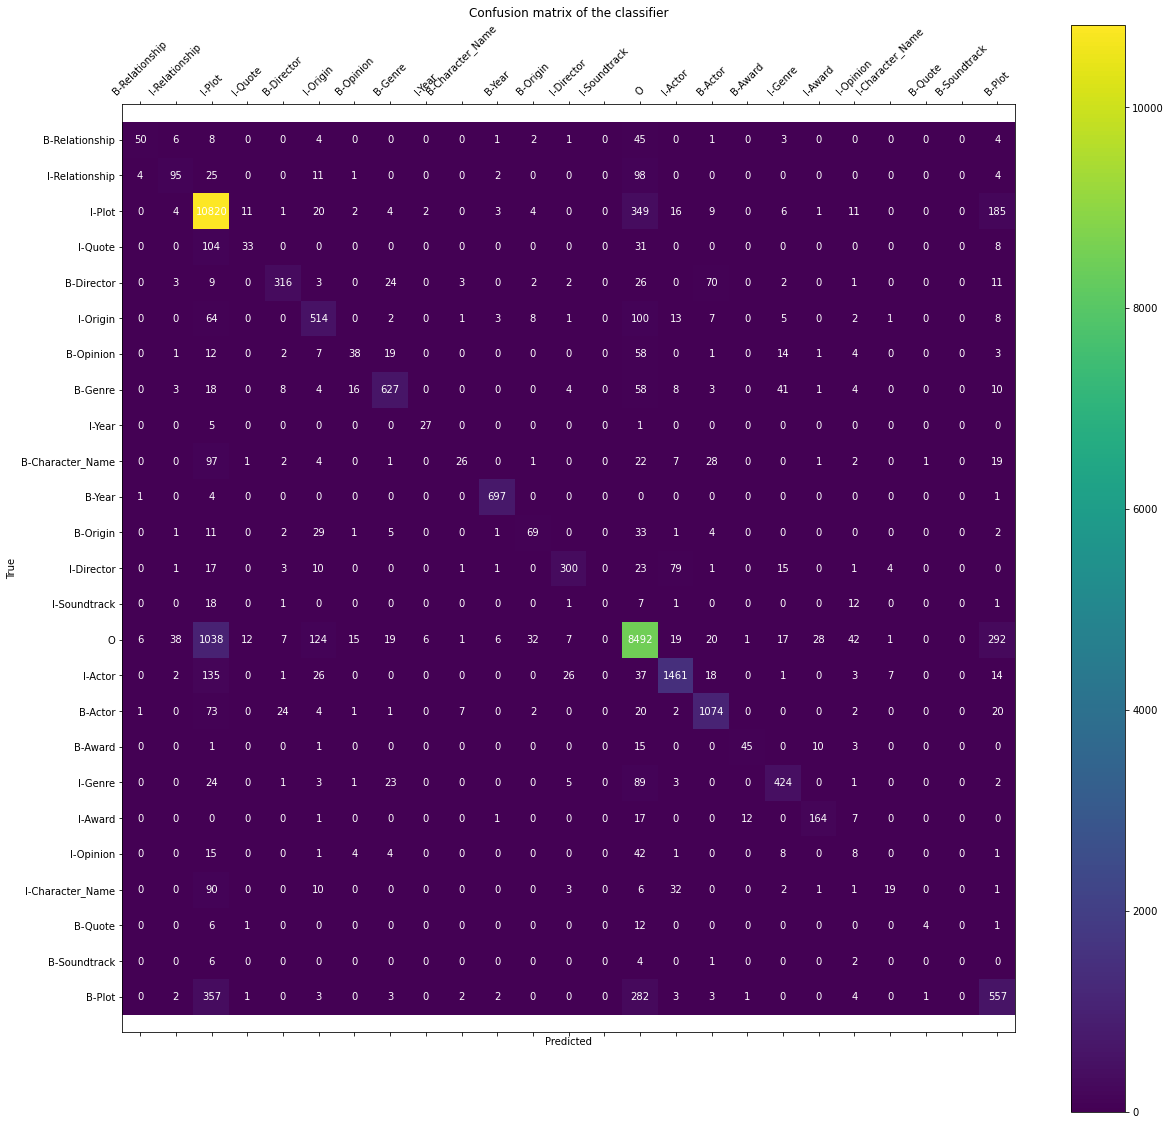

In [31]:
confusion_matrix_heatmap(y_test, preds)

# 2. Error analysis 1: False positives (5 marks)

Performing error analyses is a key part of improving your NLP applications. For the 5 classes which have the lowest precision, according to the results table from your 20% development data, print out all the sentences where there is a false positive for that class (i.e. the label is predicted in the predicted label for a given word by the tagger, but this is not present in the corresponding ground truth label for that word). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


#### Classes with least precision:
I-Soundtrack       0.00
 <br>B-Soundtrack       0.00
 <br>I-Opinion          0.07
 <br>B-Opinion          0.48
 <br>B-Plot             0.49

In [33]:
least_prec = ['I-Soundtrack', 'B-Soundtrack', 'I-Opinion', 'B-Opinion', 'B-Plot']

Storing the false positives and relevant details in a dictionary

In [34]:
preds = []
y_test = []
dic = {}
d = 0
for sent in new_test:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]

    # Running loops for predictions and true words to look for false positives for above classes
    place = 0
    for p, t in zip(sent_preds, sent_true):
        if p in least_prec: # if predicted class is in above classes
            if p!=t: # if p is a false positive
                dic[d] = {} # storing in dictionary
                dic[d]['sent'] = sent
                dic[d]['word'] = sent[place][0]
                dic[d]['pred_word'] = p
                dic[d]['true_word'] = t
                dic[d]['place'] = place
                d += 1
        place += 1

    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")


done


Converting the dictionary to a dataframe for better analysis

In [35]:
import pandas as pd 
df1 = pd.DataFrame(dic).transpose()
df1

sent           word  \
0    [(on, B-Plot), (a, I-Plot), (vacation, I-Plot)...              a   
1    [(one, O), (of, O), (the, O), (first, O), (dis...      beautiful   
2    [(orson, B-Director), (welles, I-Director), (d...     roistering   
3    [(orson, B-Actor), (wells, I-Actor), (psycholo...  psychological   
4    [(paul, B-Actor), (giamatti, I-Actor), (and, O...         thomas   
..                                                 ...            ...   
725  [(william, B-Director), (brent, I-Director), (...              a   
726  [(winona, B-Actor), (ryder, I-Actor), (is, O),...              a   
727  [(you, O), (are, O), (living, B-Plot), (in, I-...            you   
728  [(you, O), (are, O), (told, O), (that, O), (wh...            you   
729  [(you, B-Quote), (know, I-Quote), (the, I-Quot...       prefects   

    pred_word true_word place  
0      B-Plot    I-Plot     1  
1      B-Plot         O     8  
2      B-Plot    I-Plot    19  
3      B-Plot         O     2  
4      B-Plot   B-Actor     3  
..        ...       ...   ...  
725    B-Plot    I-Plot    11  
726    B-Plot   B-Actor     3  
727    B-Plot         O     0  
728    B-Plot         O     0  
729    B-Plot   I-Quote     3  

[730 rows x 5 columns]

### The predicted labels for the false positives

<AxesSubplot:>

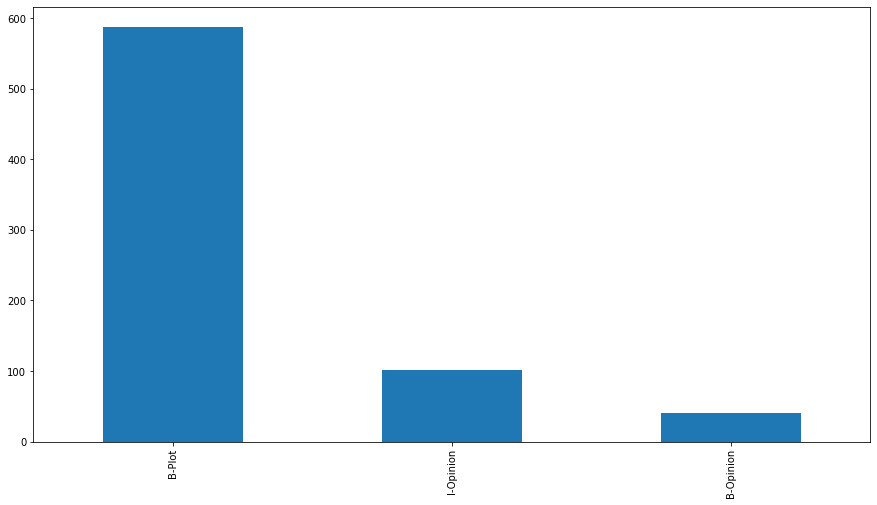

In [81]:
df1.pred_word.value_counts().plot.bar(figsize=(15, 8))

### The true values of the false positives

<AxesSubplot:>

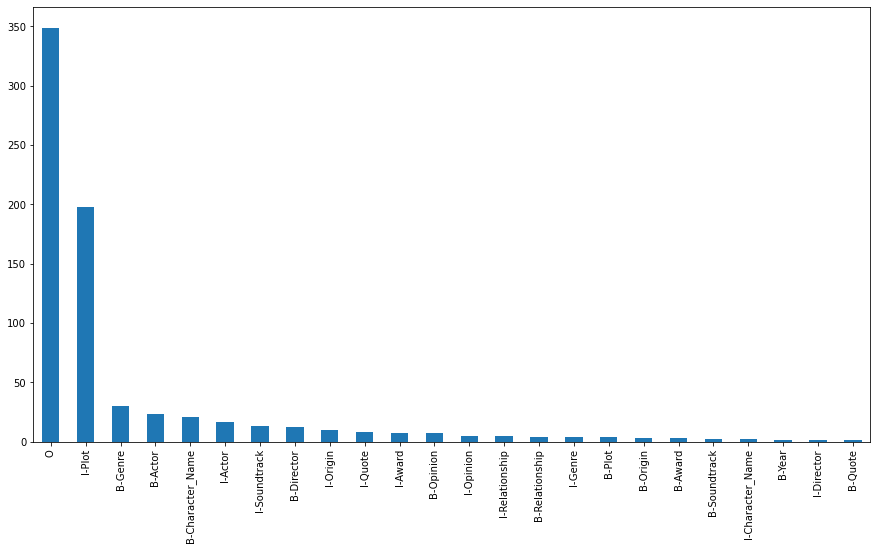

In [80]:
df1.true_word.value_counts().plot.bar(figsize=(15, 8))

### Words that were mislabeled more than 2 times

In [45]:
pred_word_counts = df1.groupby(['word', 'pred_word', 'true_word'])['sent'].count()

In [47]:
pred_word_counts[pred_word_counts>2]

word      pred_word  true_word
a         B-Plot     I-Origin      4
                     I-Plot       78
                     O            95
an        B-Plot     I-Plot        9
                     O            16
centered  B-Plot     O             8
centers   B-Plot     O            11
classic   B-Opinion  B-Genre      14
                     O             3
depicted  B-Plot     O             5
finds     B-Plot     O             7
focuses   B-Plot     O             3
follows   B-Plot     O             5
he        B-Plot     I-Plot        5
of        I-Opinion  O             4
set       B-Plot     O             6
story     B-Plot     I-Plot        9
                     O             4
takes     B-Plot     O             7
the       B-Plot     I-Plot       14
                     O            37
two       B-Plot     I-Plot        8
Name: sent, dtype: int64

### Stop words in prediction

In [63]:
stop_words_from_predictions = set(stop_words).intersection(set(df1.word.unique()))

In [70]:
stop_words_from_predictions

{'a',
 'about',
 'all',
 'an',
 'and',
 'as',
 'be',
 'but',
 'for',
 'has',
 'having',
 'he',
 'in',
 'is',
 'it',
 'most',
 'my',
 'of',
 'on',
 're',
 's',
 'the',
 'these',
 'they',
 'to',
 'who',
 'why',
 'you'}

### Percentage of false positives that were stop words

In [69]:
df1.loc[df1.word.isin(stop_words_from_predictions)].shape[0] * 100 / df1.shape[0]

43.83561643835616

### Adding stop_words to get_features
There a lot of stop words in the mislabeled tags. Therefore, maybe stopwords is a feature that could help improve the classification.

In [53]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features2(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    if token in stop_words:
        feature_list.append("STOP_WORD")
        
    feature_list.append("WORD_" + token)
    return feature_list

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ishaanchaturvedi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Training with stop words

In [54]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features2)  # initialize tagger with get_features function

print("training tagger...")
ct.train(new_train, TAGGER_PATH)
print("done")

training tagger...
done


### Testing

In [55]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features2)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

print(len(new_test), "instances")
print(sum([len(sent) for sent in new_test]), "words")

print("Storing false positive sentences for the above classes...")
preds = []
y_test = []
dic = {}
d = 0
for sent in new_test:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]

    # Running loops for predictions and true words to look for false positives for above classes
    place = 0
    for p, t in zip(sent_preds, sent_true):
        if p in least_prec: # if predicted class is in above classes
            if p!=t: # if p is a false positive
                dic[d] = {} # storing in dictionary
                dic[d]['sent'] = sent
                dic[d]['word'] = sent[place][0]
                dic[d]['pred_word'] = p
                dic[d]['true_word'] = t
                dic[d]['place'] = place
                d += 1
        place += 1

    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

1564 instances
31304 words
Storing false positive sentences for the above classes...
done


### Results

In [56]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

                  precision    recall  f1-score   support

         B-Actor       0.86      0.90      0.88      1231
         B-Award       0.78      0.60      0.68        75
B-Character_Name       0.65      0.15      0.24       212
      B-Director       0.86      0.67      0.75       472
         B-Genre       0.86      0.78      0.82       805
       B-Opinion       0.46      0.21      0.29       160
        B-Origin       0.59      0.43      0.50       159
          B-Plot       0.50      0.46      0.48      1221
         B-Quote       0.67      0.17      0.27        24
  B-Relationship       0.82      0.40      0.54       125
    B-Soundtrack       1.00      0.08      0.14        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.88      0.88      0.88      1731
         I-Award       0.79      0.81      0.80       202
I-Character_Name       0.62      0.15      0.24       165
      I-Director       0.86      0.65      0.74       456
         I-Ge

## As we can see, the scores have gone higher. Therefore stop_words helped reduce some erros.

# 3. Error analysis 2: False negatives (5 marks)

For the 5 classes which have the lowest recall, according to the results table from your 20% development data,, print out all the sentences where there is a false negative for that label (i.e. the label is present in the ground truth label for a given word, but that label is not predicted for that word by the tagger). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


### Lowest Recall for these 5 classes:
I-Soundtrack 0.00
<br> B-Soundtrack 0.00
<br> I-Opinion 0.08
<br> B-Character_Name 0.24
<br> I-Character_Name 0.30


In [71]:
lowest_recall = ['I-Soundtrack', 'B-Soundtrack', 'I-Opinion', 'B-Character_Name', 'I-Character_Name']

Storing the false negatives and relevant details in a dictionary

In [74]:
preds = []
y_test = []
dic2 = {}
d = 0
for sent in new_test:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]

    # Running loops for predictions and true words to look for false negatives for above classes
    place = 0
    for p, t in zip(sent_preds, sent_true):
        if t in lowest_recall: # if true class is in above classes
            if p!=t: # if t is a false negative
                dic2[d] = {} # storing in dictionary
                dic2[d]['sent'] = sent
                dic2[d]['word'] = sent[place][0]
                dic2[d]['pred_word'] = p
                dic2[d]['true_word'] = t
                dic2[d]['place'] = place
                d += 1
        place += 1

    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")


done


Converting the dictionary to a dataframe for better analysis

In [75]:
df3 = pd.DataFrame(dic2).transpose()
df3

sent       word pred_word  \
0    [(one, O), (of, O), (the, O), (most, B-Opinion...  memorable         O   
1    [(one, O), (of, O), (the, O), (most, B-Opinion...     scenes         O   
2    [(orson, B-Actor), (wells, I-Actor), (psycholo...      movie    I-Plot   
3    [(orson, B-Actor), (wells, I-Actor), (psycholo...         of    I-Plot   
4    [(orson, B-Actor), (wells, I-Actor), (psycholo...        all    I-Plot   
..                                                 ...        ...       ...   
443  [(will, B-Actor), (forte, I-Actor), (plays, O)...     dieter    I-Plot   
444  [(will, B-Actor), (forte, I-Actor), (plays, O)...        von    I-Plot   
445  [(will, B-Actor), (forte, I-Actor), (plays, O)...      cunth    I-Plot   
446  [(young, B-Plot), (traveler, I-Plot), (allan, ...      allan    I-Plot   
447  [(young, B-Plot), (traveler, I-Plot), (allan, ...       gray    I-Plot   

            true_word place  
0           I-Opinion     4  
1           I-Opinion     5  
2           I-Opinion    13  
3           I-Opinion    14  
4           I-Opinion    15  
..                ...   ...  
443  B-Character_Name    13  
444  I-Character_Name    14  
445  I-Character_Name    15  
446  B-Character_Name     2  
447  I-Character_Name     3  

[448 rows x 5 columns]

### The predicted labels for the false negatives

<AxesSubplot:>

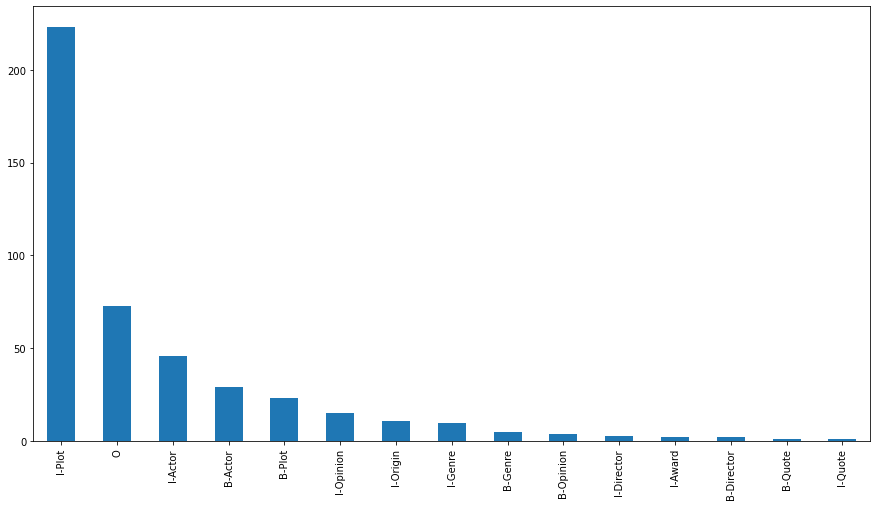

In [78]:
df3.pred_word.value_counts().plot.bar(figsize=(15, 8))

### The true values of the false negatives

<AxesSubplot:>

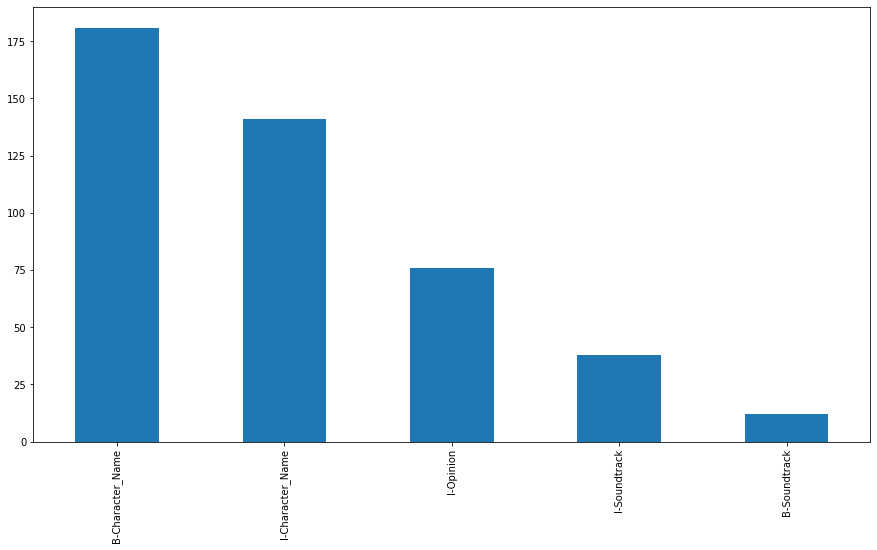

In [79]:
df3.true_word.value_counts().plot.bar(figsize=(15, 8))

### Words that were mislabeled more than 1 time

In [84]:
pred_word_counts = df3.groupby(['word', 'pred_word', 'true_word'])['sent'].count()
pred_word_counts[pred_word_counts>1]

word        pred_word  true_word       
and         I-Plot     I-Character_Name    5
bilbo       I-Plot     B-Character_Name    2
classic     B-Opinion  I-Opinion           2
            I-Genre    I-Opinion           4
cult        B-Genre    I-Opinion           2
freddy      I-Plot     B-Character_Name    2
george      I-Plot     B-Character_Name    2
harry       I-Plot     B-Character_Name    2
hit         O          I-Opinion           4
jack        I-Plot     B-Character_Name    2
james       I-Actor    I-Character_Name    2
            I-Plot     B-Character_Name    2
jay         I-Plot     B-Character_Name    2
juliet      I-Plot     I-Character_Name    2
krueger     I-Plot     I-Character_Name    2
lancelot    O          B-Character_Name    2
loki        I-Plot     B-Character_Name    2
magneto     I-Plot     B-Character_Name    2
mark        B-Actor    B-Character_Name    2
of          I-Opinion  I-Soundtrack        2
            I-Plot     I-Soundtrack        2
            O  

Most mislabeled words are names. Therefore I shall attempt POS tagging. Given how the next segment is about POS tagging, I shall directly do it in the next section.

There are also Stop Words in the mislabeled set, therefore lets see if the POS tagging helped in anyway.

In [97]:
stop_words_from_predictions = set(stop_words).intersection(set(df3.word.unique()))

In [98]:
stop_words_from_predictions

{'a',
 'about',
 'all',
 'and',
 'as',
 'at',
 'but',
 'by',
 'don',
 'for',
 'm',
 'most',
 'of',
 'on',
 're',
 's',
 'same',
 't',
 'the',
 'to'}

### Percentage of false positives that were stop words

In [99]:
df3.loc[df3.word.isin(stop_words_from_predictions)].shape[0] * 100 / df3.shape[0]

11.607142857142858

### Results

In [95]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

                  precision    recall  f1-score   support

         B-Actor       0.86      0.90      0.88      1231
         B-Award       0.78      0.60      0.68        75
B-Character_Name       0.65      0.15      0.24       212
      B-Director       0.86      0.67      0.75       472
         B-Genre       0.86      0.78      0.82       805
       B-Opinion       0.46      0.21      0.29       160
        B-Origin       0.59      0.43      0.50       159
          B-Plot       0.50      0.46      0.48      1221
         B-Quote       0.67      0.17      0.27        24
  B-Relationship       0.82      0.40      0.54       125
    B-Soundtrack       1.00      0.08      0.14        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.88      0.88      0.88      1731
         I-Award       0.79      0.81      0.80       202
I-Character_Name       0.62      0.15      0.24       165
      I-Director       0.86      0.65      0.74       456
         I-Ge

# 4. Incorporating POS tags as features (15 marks)
Use the CRF part-of-speech (POS) tagger as shown below to add POS tags to the words in the training data. Do this by altering the `preProcess` function above. Note the CRF tagger only takes strings as input so you will have to concatenate the word and POS tag together (with a special symbol, e.g. @), and you will also have to then split on this special symbol in the feature extraction function `get_features` to get the word and POS tag - modify that function so it uses the POS tag in addition to the word (currently using the word only is achieved by `feature_list.append("WORD_" + token)`. Re-run the training and testing code on your 80%/20% training/dev split from question 1 and record the results from the classification report as text in this file for comparison of the accuracy metrics against not using POS tags- try to see any improvemements across the classes.

In [102]:
# a postagger for use in exercises
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")
# example use:
words = ["john", "likes", "mary", "and", "bill"]
print(posttagger.tag(words))

[('john', 'NNP'), ('likes', 'VBZ'), ('mary', 'JJ'), ('and', 'CC'), ('bill', 'NN')]


### Adding POS tag to the word using @@ to concatenate them

In [103]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    ppe = posttagger.tag([s[0] for s in example])
    ppe2 = [pp[0] + "@@" + pp[1] for pp in ppe]
    preprocessed_example = [(pp, s[1]) for pp, s in zip(ppe2, example)]
    return preprocessed_example

In [104]:
new_train_pp = [preProcess(example) for example in new_train]

### Adding POS_tags to get_features

In [107]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features3(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    tok = tokens[idx]
    feature_list = []

    if not tok:
        return feature_list
    
    token, pos = tok.split("@@")
    feature_list.append('POS_' + pos)


    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    return feature_list

### Training with POS_tags

In [108]:
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features3)  # initialize tagger with get_features function

print("training tagger...")
ct.train(new_train_pp, TAGGER_PATH)
print("done")


training tagger...
done


### Testing

In [109]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features3)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
new_test_pp = [preProcess(example) for example in new_test]
print(len(new_test_pp), "instances")
print(sum([len(sent) for sent in new_test_pp]), "words")

print("testing tagger...")
preds = []
y_test = []
dic2 = {}
d = 0
for s_c, sent in enumerate(new_test_pp):
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    
    place = 0
    for p, t in zip(sent_preds, sent_true):

        dic2[d] = {} # storing in dictionary
        dic2[d]['sent_id'] = s_c
        dic2[d]['word'] = sent[place][0].split("@@")[0] 
        dic2[d]['pos'] = sent[place][0].split("@@")[1]
        dic2[d]['pred_word'] = p
        dic2[d]['true_word'] = t
        dic2[d]['place'] = place
        d += 1
        place += 1

    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

1564 instances
31304 words
testing tagger...
done


Storing the dictionary in a dataframe

In [116]:
df4 = pd.DataFrame(dic2).transpose()
false_labels = df4.loc[df4.pred_word!=df4.true_word]

### POS tags of mislabeled words

<AxesSubplot:>

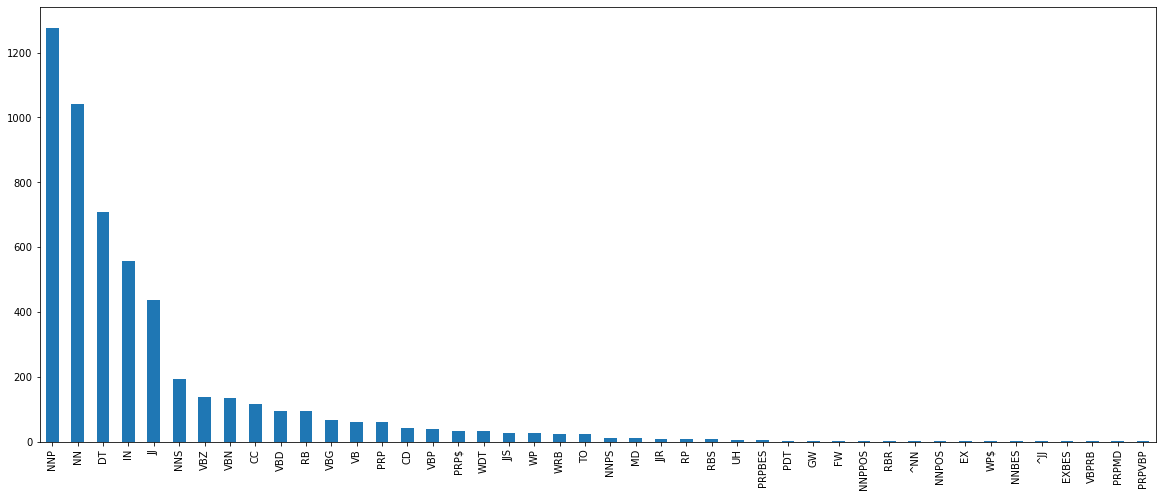

In [119]:
false_labels.pos.value_counts().plot.bar(figsize=(20,8))

### POS tags, predicted class and true class for words mislabeled more than 50 times

In [125]:
pred_word_counts = false_labels.groupby(['pos', 'pred_word', 'true_word'])['pos'].count()
pred_word_counts[pred_word_counts>50]

pos  pred_word  true_word 
CC   I-Plot     O              62
DT   B-Plot     I-Plot         99
                O             142
     I-Plot     B-Plot         71
                O             129
     O          I-Plot         58
IN   I-Plot     O             197
     O          B-Plot         76
                I-Plot         73
JJ   I-Plot     O              63
NN   I-Plot     B-Plot         84
                O             205
     O          I-Plot         77
NNP  B-Actor    B-Director     64
     I-Actor    I-Director     70
     I-Plot     O              64
Name: pos, dtype: int64

### Results

In [112]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

/Users/ishaanchaturvedi/opt/anaconda3/envs/netx/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ishaanchaturvedi/opt/anaconda3/envs/netx/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ishaanchaturvedi/opt/anaconda3/envs/netx/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

                  precision    recall  f1-score   support

         B-Actor       0.86      0.89      0.87      1231
         B-Award       0.78      0.61      0.69        75
B-Character_Name       0.56      0.13      0.21       212
      B-Director       0.85      0.69      0.76       472
         B-Genre       0.86      0.78      0.82       805
       B-Opinion       0.52      0.26      0.34       160
        B-Origin       0.53      0.42      0.47       159
          B-Plot       0.49      0.46      0.48      1221
         B-Quote       0.57      0.17      0.26        24
  B-Relationship       0.84      0.50      0.63       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.88      0.88      0.88      1731
         I-Award       0.79      0.79      0.79       202
I-Character_Name       0.53      0.15      0.24       165
      I-Director       0.86      0.68      0.76       456
         I-Ge

/Users/ishaanchaturvedi/opt/anaconda3/envs/netx/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Heatmap

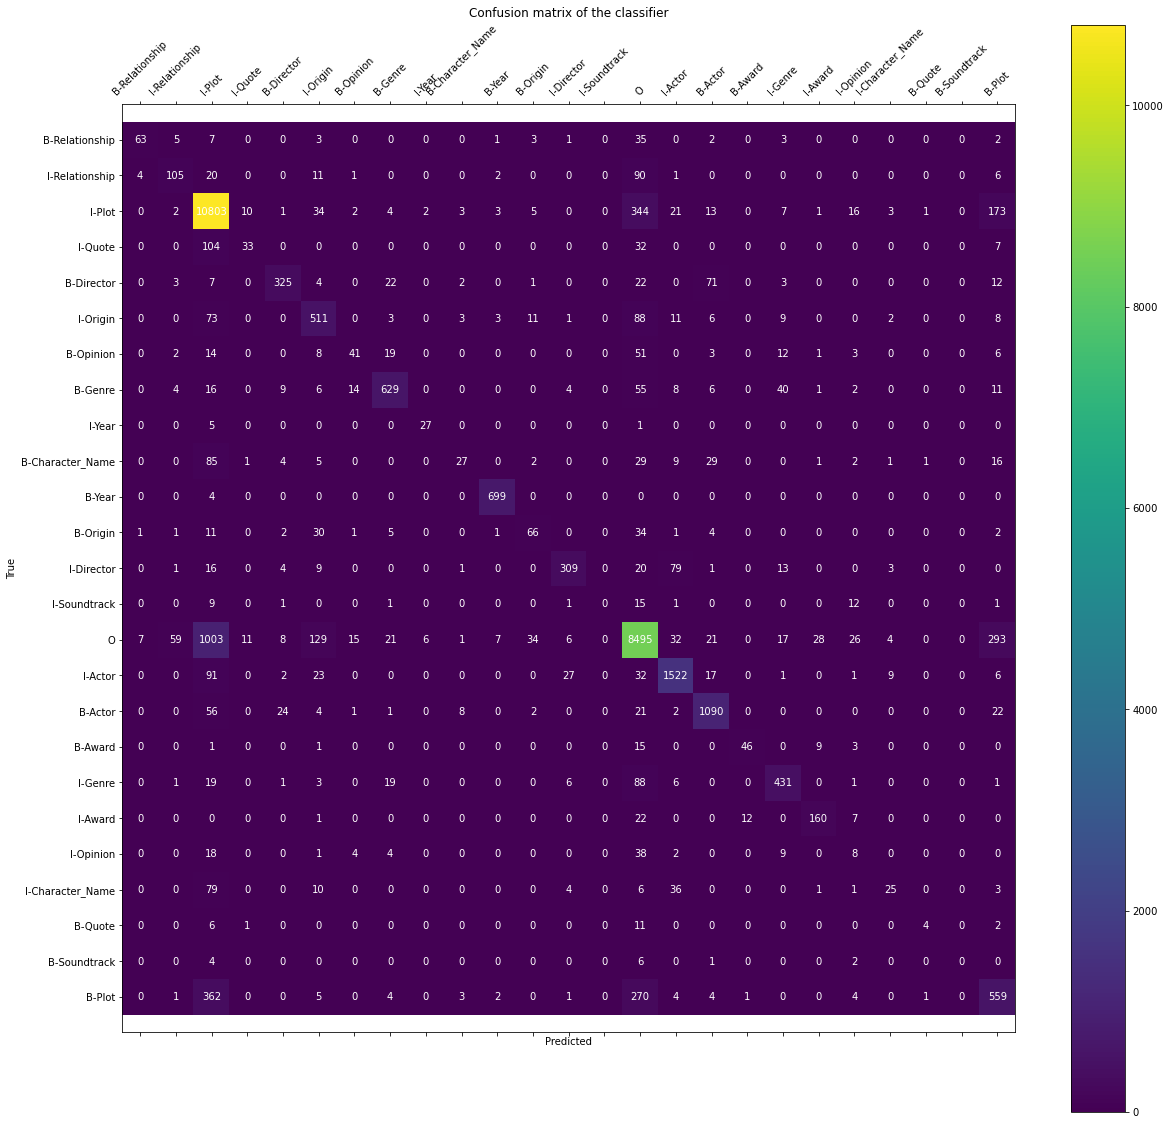

In [113]:
confusion_matrix_heatmap(y_test, preds)

### Transition Weights

In [114]:
print_transition_weights(ct._tagger.info().transitions.items())

8.557380 B-Plot   -> I-Plot
8.334401 B-Actor  -> I-Actor
8.022544 I-Plot   -> I-Plot
7.591820 B-Origin -> I-Origin
7.457602 I-Quote  -> I-Quote
7.402352 B-Director -> I-Director
7.255067 I-Origin -> I-Origin
7.079026 B-Relationship -> I-Relationship
6.980549 I-Relationship -> I-Relationship
6.971271 I-Opinion -> I-Opinion
6.897719 B-Quote  -> I-Quote
6.781196 B-Character_Name -> I-Character_Name
6.556626 I-Soundtrack -> I-Soundtrack
6.550705 B-Genre  -> I-Genre
6.532666 B-Opinion -> I-Opinion
6.377127 B-Award  -> I-Award
6.350814 I-Award  -> I-Award
6.223850 I-Genre  -> I-Genre
6.156998 B-Soundtrack -> I-Soundtrack
5.741791 I-Actor  -> I-Actor
5.513957 I-Character_Name -> I-Character_Name
4.598803 I-Year   -> I-Year
4.571038 I-Director -> I-Director
3.905021 B-Year   -> I-Year
3.790692 B-Character_Name -> B-Plot
3.382297 I-Character_Name -> B-Plot
3.214821 O        -> O
3.044119 O        -> B-Plot
2.983711 B-Plot   -> B-Character_Name
2.952191 I-Actor  -> B-Plot
2.778373 B-Opinion -> B

### Predictive state features

In [115]:
print_most_predictive_state_features(ct._tagger.info().state_features.items())

5.626451 B-Year   HAS_NUM
4.138643 I-Year   WORD_s
3.737607 B-Genre  WORD_animated
2.847085 B-Genre  WORD_action
2.806361 B-Genre  WORD_thriller
2.559861 B-Relationship SUF_uel
2.542186 B-Award  WORD_oscar
2.530894 B-Opinion WORD_blockbuster
2.468939 I-Genre  WORD_animated
2.449240 I-Genre  WORD_fiction
2.425939 B-Actor  WORD_cher
2.422836 B-Award  SUF_car
2.351547 B-Genre  WORD_animation
2.342749 B-Actor  WORD_fred
2.342530 B-Genre  WORD_slasher
2.323292 B-Genre  WORD_comedy
2.314416 B-Genre  WORD_war
2.297333 I-Genre  WORD_thriller
2.288035 B-Genre  WORD_horror
2.286781 B-Director WORD_disney
2.173674 I-Actor  WORD_cage
2.155690 B-Opinion WORD_masterpiece
2.133171 B-Director SUF_xar
2.133171 B-Director WORD_pixar
2.125634 B-Genre  WORD_musical
2.121343 B-Relationship WORD_remake
2.117493 B-Relationship WORD_sequel
2.114544 B-Genre  WORD_documentary
2.111191 B-Quote  WORD_i
2.105321 B-Origin WORD_adapted
2.100763 I-Genre  WORD_war
2.063894 B-Award  WORD_oscars
2.063327 B-Character_Nam

0.553123 I-Actor  WORD_hawke
0.553047 B-Plot   SUF_nds
0.552828 I-Relationship SUF_p
0.552773 I-Actor  WORD_baruchel
0.552431 B-Actor  SUF_uba
0.552418 B-Quote  SUF_ave
0.552370 B-Actor  WORD_emma
0.552353 I-Character_Name SUF_ace
0.552352 B-Actor  WORD_jessica
0.552335 I-Director WORD_palma
0.552286 I-Character_Name WORD_bucket
0.552110 B-Actor  SUF_ell
0.551883 B-Year   SUF_44
0.551883 B-Year   SUF_944
0.551883 B-Year   WORD_1944
0.551710 I-Director SUF_ock
0.551648 I-Quote  SUF_tes
0.551578 I-Plot   WORD_cia
0.551443 B-Genre  SUF_sic
0.551388 B-Director WORD_mike
0.551273 B-Character_Name SUF_up
0.551248 I-Plot   SUF_iff
0.551216 B-Character_Name WORD_colonel
0.551170 B-Plot   DT
0.551060 I-Relationship SUF_use
0.550941 B-Plot   WORD_married
0.550917 B-Actor  WORD_adrian
0.550848 B-Actor  WORD_roy
0.550635 I-Plot   WORD_together
0.550451 I-Director SUF_lma
0.550298 I-Award  WORD_actor
0.550152 I-Plot   WORD_prostitute
0.550139 I-Genre  WORD_family
0.549754 I-Plot   WORD_possession
0

0.409914 B-Relationship WORD_after
0.409892 I-Actor  WORD_toro
0.409890 I-Relationship WORD_mickey
0.409671 B-Actor  WORD_marcello
0.409643 B-Plot   WORD_precrime
0.409603 B-Relationship WORD_90
0.409550 I-Actor  WORD_howard
0.409533 I-Opinion WORD_explosions
0.409492 B-Actor  SUF_ake
0.409492 I-Actor  WORD_boom
0.409487 B-Genre  WORD_tear
0.409461 I-Quote  WORD_chopsticks
0.409456 I-Relationship WORD_parts
0.409393 I-Plot   WORD_investigator
0.409389 B-Award  WORD_song
0.409084 B-Plot   WORD_while
0.409036 I-Character_Name WORD_blake
0.409004 B-Character_Name SUF_uts
0.408990 B-Plot   WORD_sentient
0.408983 B-Character_Name WORD_phoenix
0.408967 I-Origin SUF_ris
0.408959 B-Plot   WORD_reassembled
0.408937 B-Character_Name WORD_lucas
0.408904 I-Relationship WORD_upon
0.408875 B-Origin WORD_melville
0.408843 I-Origin WORD_lamotta
0.408790 B-Origin WORD_novels
0.408764 B-Character_Name SUF_so
0.408687 B-Opinion WORD_weird
0.408665 I-Relationship WORD_final
0.408638 I-Character_Name WORD_

0.315723 B-Actor  WORD_milla
0.315719 I-Plot   WORD_tortured
0.315632 B-Origin SUF_tv
0.315632 B-Origin WORD_mtv
0.315611 B-Plot   WORD_personalities
0.315567 I-Quote  SUF_am
0.315560 I-Director SUF_hen
0.315532 I-Character_Name WORD_binks
0.315506 I-Relationship SUF_his
0.315506 I-Relationship WORD_this
0.315436 B-Quote  WORD_quite
0.315269 B-Genre  WORD_summer
0.315257 I-Genre  SUF_ult
0.315176 I-Director SUF_rie
0.315155 B-Actor  SUF_ona
0.315070 I-Director NNPS
0.315041 B-Character_Name SUF_p
0.314999 I-Plot   WORD_destroyed
0.314991 B-Plot   WORD_hears
0.314963 I-Plot   WORD_dog
0.314858 I-Relationship WORD_parents
0.314662 B-Plot   WORD_trapped
0.314598 I-Director SUF_ch
0.314563 I-Plot   SUF_97
0.314531 B-Plot   WORD_teaches
0.314516 B-Actor  WORD_common
0.314478 I-Plot   WORD_apocalyptic
0.314477 B-Genre  SUF_res
0.314439 I-Relationship SUF_chi
0.314428 I-Quote  WORD_life
0.314416 B-Plot   WORD_focusses
0.314377 I-Origin WORD_romero
0.314298 I-Opinion WORD_so
0.314270 I-Plot   

0.227606 B-Genre  WORD_based
0.227552 I-Plot   WORD_crossdresses
0.227507 I-Character_Name WORD_poe
0.227434 B-Plot   WORD_murdering
0.227380 I-Director SUF_mas
0.227365 B-Plot   WORD_lead
0.227345 I-Award  PRPBES
0.227309 I-Actor  WORD_billy
0.227252 I-Plot   SUF_ssy
0.227251 I-Award  WORD_its
0.227242 B-Plot   WORD_falls
0.227200 I-Plot   WORD_johnson
0.227178 B-Plot   SUF_ssa
0.227148 B-Plot   SUF_il
0.227143 I-Plot   WORD_instructed
0.227104 I-Plot   WORD_scarlett
0.227101 I-Character_Name SUF_lls
0.227100 I-Character_Name SUF_nny
0.227019 B-Plot   WORD_mother
0.226999 I-Plot   WORD_version
0.226993 I-Actor  SUF_wis
0.226993 I-Actor  WORD_lewis
0.226985 I-Origin WORD_carl
0.226875 B-Plot   WORD_furry
0.226874 I-Plot   WORD_candidate
0.226848 I-Character_Name SUF_um
0.226680 I-Origin WORD_neil
0.226638 B-Plot   SUF_lor
0.226616 I-Quote  SUF_son
0.226572 I-Plot   WORD_burns
0.226394 I-Actor  SUF_id
0.226394 B-Plot   SUF_ew
0.226387 B-Director WORD_carl
0.226336 B-Plot   WORD_birds
0.

0.141395 I-Plot   WORD_collects
0.141388 I-Quote  WORD_sight
0.141225 I-Plot   WORD_switches
0.141160 I-Plot   SUF_ri
0.141099 I-Plot   SUF_pet
0.141098 I-Actor  WORD_robards
0.141021 I-Actor  WORD_bloom
0.141002 I-Origin WORD_been
0.140960 I-Relationship WORD_american
0.140897 I-Plot   WORD_retelling
0.140838 I-Origin SUF_ote
0.140804 B-Plot   SUF_ef
0.140779 I-Director WORD_jordan
0.140713 B-Relationship SUF_ree
0.140706 I-Director SUF_hi
0.140687 I-Actor  NNPS
0.140650 B-Plot   WORD_invisible
0.140566 I-Plot   WORD_skills
0.140565 I-Plot   SUF_pth
0.140565 I-Plot   WORD_depth
0.140558 I-Character_Name SUF_ks
0.140552 B-Actor  WORD_vincente
0.140537 I-Plot   SUF_ill
0.140526 B-Genre  WORD_brazilian
0.140512 I-Opinion SUF_ly
0.140506 B-Plot   WORD_chronicling
0.140504 B-Plot   SUF_law
0.140416 I-Plot   WORD_curator
0.140407 B-Plot   SUF_ora
0.140367 I-Actor  WORD_elizabeth
0.140331 I-Character_Name WORD_emmett
0.140225 B-Actor  SUF_ibi
0.140225 B-Actor  WORD_bibi
0.140220 I-Actor  SUF

0.062928 I-Plot   WORD_psychologist
0.062903 I-Director SUF_r
0.062758 I-Director WORD_man
0.062727 I-Genre  SUF_py
0.062701 B-Plot   SUF_ure
0.062701 I-Plot   WORD_transferred
0.062675 I-Genre  SUF_gic
0.062594 B-Actor  SUF_hny
0.062594 B-Actor  WORD_johny
0.062579 B-Plot   WORD_dystopian
0.062572 I-Director SUF_ak
0.062547 I-Plot   WORD_potions
0.062495 I-Plot   WORD_backyard
0.062444 I-Plot   WORD_trash
0.062442 I-Plot   WORD_swoops
0.062432 I-Plot   WORD_wants
0.062375 B-Director SUF_ger
0.062265 I-Plot   WORD_baron
0.062258 I-Plot   SUF_lle
0.062176 I-Plot   WORD_skateboard
0.062133 I-Plot   WORD_implanted
0.062035 I-Actor  WORD_halle
0.062021 I-Quote  SUF_eel
0.061992 I-Plot   WORD_planning
0.061931 I-Director SUF_w
0.061923 I-Plot   WORD_messy
0.061916 I-Director SUF_ns
0.061854 I-Plot   WORD_interests
0.061826 I-Plot   WORD_fascination
0.061749 B-Plot   WORD_autistic
0.061747 I-Plot   WORD_holds
0.061721 I-Plot   WORD_sharp
0.061608 I-Plot   WORD_austria
0.061597 I-Actor  SUF_o

0.010532 I-Plot   WORD_forebodings
0.010510 I-Plot   WORD_pours
0.010498 I-Plot   WORD_issue
0.010479 I-Plot   WORD_sown
0.010454 B-Plot   WORD_both
0.010446 I-Plot   SUF_zon
0.010446 I-Plot   WORD_amazon
0.010437 I-Plot   WORD_awoken
0.010433 I-Plot   WORD_ruled
0.010407 I-Plot   WORD_policemen
0.010393 B-Plot   WORD_flying
0.010390 I-Plot   SUF_eny
0.010390 I-Plot   WORD_deny
0.010384 I-Director SUF_uki
0.010373 I-Plot   WORD_fortuitous
0.010365 I-Plot   WORD_regulate
0.010351 I-Opinion VB
0.010340 I-Plot   WORD_infraction
0.010335 I-Plot   WORD_starvation
0.010333 I-Plot   WORD_civilized
0.010326 I-Plot   WORD_camping
0.010323 I-Character_Name JJR
0.010315 I-Plot   WORD_plaid
0.010314 I-Plot   WORD_advocating
0.010285 I-Plot   WORD_idealism
0.010268 I-Plot   WORD_mermaids
0.010267 I-Plot   WORD_gravely
0.010260 I-Plot   WORD_pastry
0.010256 I-Plot   WORD_uncovering
0.010254 I-Plot   WORD_poisoned
0.010251 I-Plot   WORD_saucer
0.010250 I-Plot   WORD_commands
0.010241 I-Plot   WORD_pe

-0.134764 I-Relationship SUF_ime
-0.134968 I-Plot   WORD_self
-0.135007 I-Plot   WORD_hands
-0.135010 I-Origin SUF_ey
-0.135036 I-Genre  SUF_ay
-0.135049 I-Plot   SUF_rro
-0.135375 I-Actor  WORD_boyle
-0.135574 I-Plot   WORD_peace
-0.135592 I-Plot   WORD_clue
-0.135646 B-Plot   WORD_working
-0.135802 I-Quote  WORD_him
-0.135819 I-Plot   WORD_korean
-0.135846 I-Quote  JJR
-0.135888 I-Origin SUF_w
-0.135890 I-Plot   WORD_taught
-0.136155 I-Actor  SUF_ob
-0.136387 I-Character_Name WORD_t
-0.136804 I-Plot   WORD_past
-0.136896 I-Plot   SUF_lop
-0.137121 B-Genre  WORD_blockbuster
-0.137167 I-Plot   WORD_origins
-0.137194 B-Plot   WORD_its
-0.137331 I-Plot   SUF_mp
-0.137419 I-Plot   WORD_than
-0.137465 I-Plot   SUF_lis
-0.137518 I-Plot   WORD_martial
-0.137552 I-Plot   SUF_my
-0.137578 I-Plot   WORD_sinking
-0.137626 I-Plot   WORD_law
-0.137662 B-Relationship SUF_ous
-0.137867 B-Relationship SUF_ry
-0.137994 B-Plot   SUF_ser
-0.138070 I-Plot   SUF_tep
-0.138070 I-Plot   WORD_step
-0.138133 

# 5. Feature experimentation and other optimization for optimal macro average (30 marks).
Experiment with different features by further adjusting the `get_features` function, and modifying it to get the best results in terms of `macro average f-score` (i.e. average f-score across all classes) on your 20% development data. Iteratively try different functions, briefly describe the method and record the results in the classification report format and make sure you describe this in your report.

Feature tips: You could try more suffixes/prefixes of the current word than those currently extracted, you could use windows of the next and previous tokens (of different sizes, e.g. the previous/next N words/tags). As you try different feature functions, use the techniques you used in Q2 and Q3 to see the kind of errors you are getting for lower performing classes, in addition to the confusion matrix over classes.

Model tips: After your feature engineering, for even better performance you could try optimizing the hyperparameters by adjusting the `training_opt` dictionary values, experimenting with changing the minimum document frequency, c1 and c2 regularization parameters for https://www.nltk.org/api/nltk.tag.crf.html#nltk.tag.crf.CRFTagger.__init__ e.g. changing the initialization to make the minimum feature frequency 2 (rather than the default 1) would be:

`ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":2})`

Leave the `get_features` functions in the state you used to get the highest `macro average f-score` on your 20% development set, then re-train the model on ALL the training data and print the classification report for the original test data (i.e. from the test file `trivia10k13train.bio.txt`) as your final piece of code.

In [126]:
def get_features4(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    feature_list = []
    stop_words = set(stopwords.words('english'))
    porter_stemmer = PorterStemmer()    

    
    for i in range(0, 1):
        tok = tokens[idx-i]

        if tok:

            token, pos = tok.split("@@")
            feature_list.append('POS_' + pos)
            
            token = porter_stemmer.stem(token)
                
            
            # Length of word
            feature_list.append("LEN_"+str(len(token)))

            # Number
            if re.search(_pattern, token) is not None:
                feature_list.append("HAS_NUM")

            # Punctuation
            punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
            if all(unicodedata.category(x) in punc_cat for x in token):
                feature_list.append("PUNCTUATION")

            # Suffix up to length 3
            if len(token) > 1:
                feature_list.append("SUF_" + token[-1:])
            if len(token) > 2:
                feature_list.append("SUF_" + token[-2:])
            if len(token) > 3:
                feature_list.append("SUF_" + token[-3:])
        

            # Prefix up to length 3
            if len(token) > 1:
                feature_list.append("SUF_" + token[:1])
            if len(token) > 2:
                feature_list.append("SUF_" + token[:2])
            if len(token) > 3:
                feature_list.append("SUF_" + token[:3])

            feature_list.append("WORD_" + token)
            #print(feature_list)
            
    for i in range(1, 4):
        if len(tokens)>i-1:
            tok = tokens[idx-i]
            if tok:

                token, pos = tok.split("@@")

                feature_list.append('POS_' + pos)
                
                if idx-i == len(tokens)-1:
                    feature_list.append("IS_LAST")
                    
                if idx-i==0:
                    feature_list.append("IS_FIRST")
                    
                
                if token in stop_words:
                    feature_list.append("STOP_WORDS")
                
                feature_list.append("WORD_" + token)
                #print(feature_list)


    return feature_list


In [154]:
new_train_pp

[[('steve@@PRPVBP', 'B-Actor'),
  ('mcqueen@@VBN', 'I-Actor'),
  ('provided@@VBN', 'O'),
  ('a@@DT', 'O'),
  ('thrilling@@NN', 'B-Plot'),
  ('motorcycle@@NN', 'I-Plot'),
  ('chase@@NN', 'I-Plot'),
  ('in@@IN', 'I-Plot'),
  ('this@@DT', 'I-Plot'),
  ('greatest@@JJS', 'B-Opinion'),
  ('of@@IN', 'I-Opinion'),
  ('all@@DT', 'I-Opinion'),
  ('ww@@NNP', 'B-Plot'),
  ('2@@NNP', 'I-Plot'),
  ('prison@@NNP', 'I-Plot'),
  ('escape@@NN', 'I-Plot'),
  ('movies@@NNS', 'I-Plot')],
 [('liza@@NNP', 'B-Actor'),
  ('minnelli@@NNP', 'I-Actor'),
  ('and@@CC', 'O'),
  ('joel@@NNP', 'B-Actor'),
  ('gray@@NNP', 'I-Actor'),
  ('won@@NNP', 'B-Award'),
  ('oscars@@NNS', 'I-Award'),
  ('for@@IN', 'O'),
  ('their@@PRP$', 'O'),
  ('roles@@NNS', 'O'),
  ('in@@IN', 'O'),
  ('this@@DT', 'O'),
  ('1972@@NN', 'B-Year'),
  ('movie@@NN', 'O'),
  ('that@@WDT', 'B-Plot'),
  ('follows@@VBZ', 'I-Plot'),
  ('nightclub@@NN', 'I-Plot'),
  ('entertainers@@NNS', 'I-Plot'),
  ('in@@IN', 'I-Plot'),
  ('berlin@@NNP', 'I-Plot'),
  ('

In [129]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features4, training_opt={"feature.possible_states":2, "num_memories": 10, "epsilon": 2}) 

print("training tagger...")
ct.train(new_train_pp, TAGGER_PATH)
print("done")

training tagger...
done


In [150]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features4)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
new_test_pp = [preProcess(example) for example in new_test]


print("testing tagger...")
preds = []
y_test = []
dic2 = {}
d = 0
for s_c, sent in enumerate(new_test_pp):
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    
    place = 0
    for p, t in zip(sent_preds, sent_true):

        dic2[d] = {} # storing in dictionary
        dic2[d]['sent_id'] = s_c
        dic2[d]['word'] = sent[place][0].split("@@")[0] 
        dic2[d]['pos'] = sent[place][0].split("@@")[1]
        dic2[d]['pred_word'] = p
        dic2[d]['true_word'] = t
        dic2[d]['place'] = place
        d += 1
        place += 1

    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")


testing tagger...
done


In [152]:
preds

['B-Actor',
 'I-Actor',
 'O',
 'B-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'B-Actor',
 'I-Actor',
 'B-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'O',
 'O',
 'B-Year',
 'B-Award',
 'I-Award',
 'O',
 'B-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Genre',
 'O',
 'O',
 'B-Plot',
 'I-Plot',
 'I-Plot',
 'O',
 'O',
 'B-Actor',
 'I-Actor',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Director',
 'I-Director',
 'O',
 'B-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'O',
 'O',
 'O',
 'O',
 'B-Director',
 'B-Genre',
 'O',
 'O',
 'O',

In [151]:
y_test

['B-Actor',
 'I-Actor',
 'O',
 'B-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'B-Actor',
 'I-Actor',
 'B-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'O',
 'O',
 'B-Year',
 'B-Award',
 'O',
 'B-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Relationship',
 'I-Relationship',
 'I-Relationship',
 'I-Relationship',
 'I-Relationship',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Genre',
 'O',
 'O',
 'B-Plot',
 'I-Plot',
 'I-Plot',
 'O',
 'O',
 'B-Actor',
 'I-Actor',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Director',
 'I-Director',
 'O',
 'B-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'O'

In [149]:
new_test_pp

[[('omar@@NNP', 'B-Actor'),
  ('sharif@@NNP', 'I-Actor'),
  ('is@@VBZ', 'O'),
  ('a@@DT', 'B-Plot'),
  ('married@@JJ', 'I-Plot'),
  ('man@@NN', 'I-Plot'),
  ('who@@WP', 'I-Plot'),
  ('falls@@VBZ', 'I-Plot'),
  ('in@@IN', 'I-Plot'),
  ('love@@NN', 'I-Plot'),
  ('with@@IN', 'I-Plot'),
  ('julie@@NNP', 'B-Actor'),
  ('christie@@NNP', 'I-Actor'),
  ('during@@IN', 'B-Plot'),
  ('the@@DT', 'I-Plot'),
  ('bolshevik@@NN', 'I-Plot'),
  ('revolution@@NN', 'I-Plot'),
  ('in@@IN', 'O'),
  ('this@@DT', 'O'),
  ('1965@@NNP', 'B-Year'),
  ('oscar@@NNP', 'B-Award'),
  ('winner@@NNP', 'O')],
 [('on@@IN', 'B-Plot'),
  ('a@@DT', 'I-Plot'),
  ('vacation@@NN', 'I-Plot'),
  ('in@@IN', 'I-Plot'),
  ('paris@@NNP', 'I-Plot'),
  ('one@@CD', 'I-Plot'),
  ('of@@IN', 'I-Plot'),
  ('three@@CD', 'I-Plot'),
  ('travelers@@NNS', 'I-Plot'),
  ('is@@VBZ', 'I-Plot'),
  ('mistaken@@VBN', 'I-Plot'),
  ('for@@IN', 'I-Plot'),
  ('a@@DT', 'I-Plot'),
  ('british@@JJ', 'I-Plot'),
  ('heiress@@NN', 'I-Plot')],
 [('on@@IN', 'O'),

In [133]:
df5 = pd.DataFrame(dic2).transpose()
false_labels = df5.loc[df5.pred_word!=df5.true_word]

<AxesSubplot:>

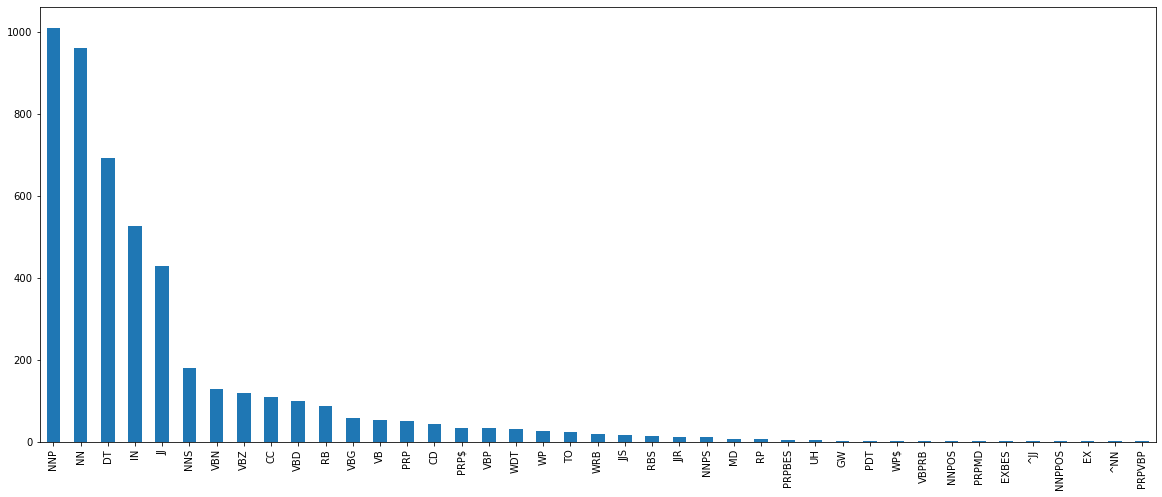

In [134]:
false_labels.pos.value_counts().plot.bar(figsize=(20,8))

<AxesSubplot:>

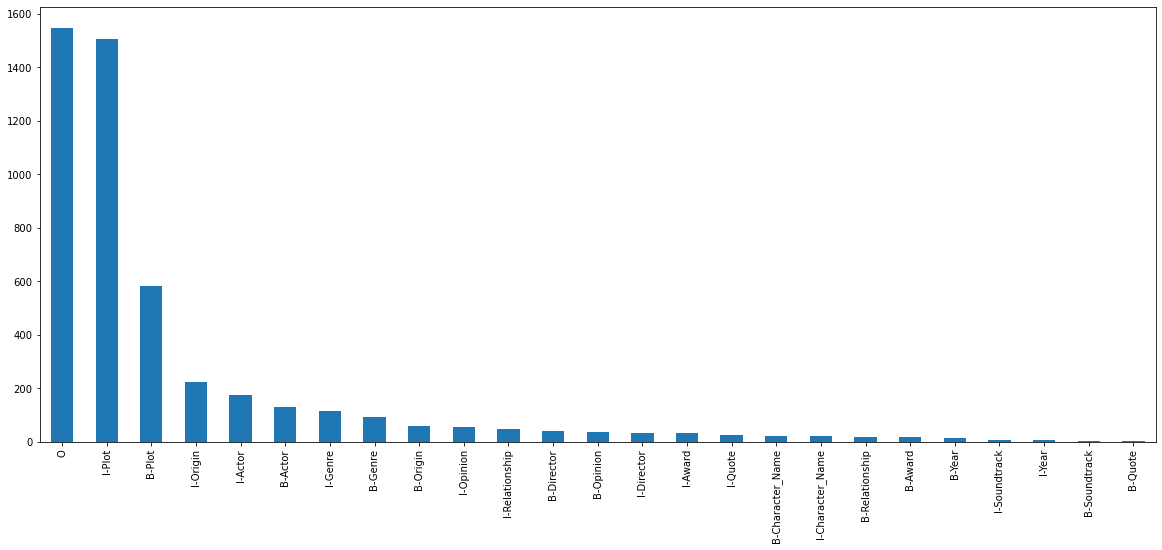

In [136]:
false_labels.pred_word.value_counts().plot.bar(figsize=(20,8))

<AxesSubplot:>

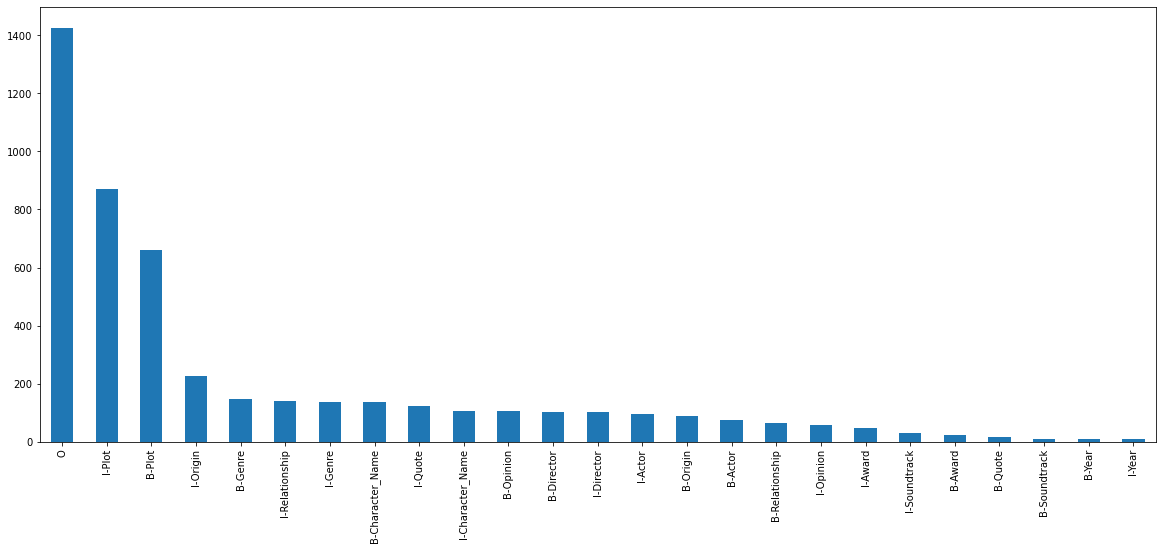

In [137]:
false_labels.true_word.value_counts().plot.bar(figsize=(20,8))

In [139]:
training_data = [preProcess(example) for example in training_data]

In [142]:
# Final results on original test data, using all training data, with best settings from dev set:

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")


# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features4, training_opt={"feature.possible_states":2, "num_memories": 10}) 

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

# load tagger from saved file
ct = CRFTagger(feature_func=get_features4, training_opt={"feature.possible_states":2, "num_memories": 10}) 
ct.set_model_file(TAGGER_PATH)  # load model from file

print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

print("testing tagger on test data...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

1953 instances
39035 words
training tagger...
done
1953 instances
39035 words
testing tagger on test data...
done


In [146]:
test_data

[[('i@@PRP', 'O'),
  ('need@@VBP', 'O'),
  ('that@@DT', 'O'),
  ('movie@@NN', 'O'),
  ('which@@WDT', 'O'),
  ('involves@@VBZ', 'O'),
  ('aliens@@NNPPOS', 'B-Plot'),
  ('invading@@NNP', 'I-Plot'),
  ('earth@@NNP', 'I-Plot'),
  ('in@@IN', 'I-Plot'),
  ('a@@DT', 'I-Plot'),
  ('particular@@JJ', 'I-Plot'),
  ('united@@NNP', 'I-Plot'),
  ('states@@NNPS', 'I-Plot'),
  ('place@@NN', 'I-Plot'),
  ('in@@IN', 'I-Plot'),
  ('california@@NNP', 'I-Plot')],
 [('what@@WP', 'O'),
  ('soviet@@NNP', 'B-Genre'),
  ('science@@NNP', 'I-Genre'),
  ('fiction@@NN', 'I-Genre'),
  ('classic@@NN', 'B-Opinion'),
  ('about@@IN', 'O'),
  ('a@@DT', 'B-Plot'),
  ('mysterious@@JJ', 'I-Plot'),
  ('planet@@NN', 'I-Plot'),
  ('was@@VBD', 'O'),
  ('later@@RB', 'O'),
  ('remade@@VB', 'B-Relationship'),
  ('by@@IN', 'O'),
  ('steven@@NNP', 'B-Director'),
  ('soderbergh@@NNP', 'I-Director'),
  ('and@@CC', 'O'),
  ('george@@NNP', 'B-Actor'),
  ('clooney@@NNP', 'I-Actor')],
 [('this@@DT', 'O'),
  ('american@@JJ', 'B-Genre'),
  

In [144]:
y_test

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'O',
 'B-Genre',
 'I-Genre',
 'I-Genre',
 'B-Opinion',
 'O',
 'B-Plot',
 'I-Plot',
 'I-Plot',
 'O',
 'O',
 'B-Relationship',
 'O',
 'B-Director',
 'I-Director',
 'O',
 'B-Actor',
 'I-Actor',
 'O',
 'B-Genre',
 'I-Genre',
 'O',
 'O',
 'B-Origin',
 'I-Origin',
 'I-Origin',
 'I-Origin',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Actor',
 'I-Actor',
 'O',
 'B-Year',
 'O',
 'O',
 'B-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'O',
 'O',
 'O',
 'B-Actor',
 'I-Actor',
 'O',
 'O',
 'B-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'O',
 'B-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'O',
 'B-Genre',
 'I-Genre'

In [145]:
preds

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'O',
 'O',
 'B-Genre',
 'I-Genre',
 'I-Genre',
 'O',
 'B-Plot',
 'I-Plot',
 'I-Plot',
 'O',
 'O',
 'O',
 'O',
 'B-Director',
 'I-Director',
 'O',
 'B-Actor',
 'I-Actor',
 'O',
 'B-Genre',
 'I-Genre',
 'O',
 'O',
 'B-Origin',
 'I-Origin',
 'I-Origin',
 'I-Origin',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-Actor',
 'I-Actor',
 'O',
 'B-Year',
 'O',
 'B-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'O',
 'O',
 'O',
 'B-Actor',
 'I-Actor',
 'O',
 'O',
 'B-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'I-Plot',
 'O',
 'B-Opinion',
 'B-Genre',
 'I-Gen

In [143]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))

                  precision    recall  f1-score   support

         B-Actor       0.91      0.94      0.92      1274
         B-Award       0.74      0.73      0.73        66
B-Character_Name       0.69      0.40      0.51       283
      B-Director       0.87      0.85      0.86       425
         B-Genre       0.81      0.78      0.79       789
       B-Opinion       0.47      0.36      0.41       195
        B-Origin       0.44      0.35      0.39       190
          B-Plot       0.51      0.49      0.50      1577
         B-Quote       0.89      0.36      0.52        47
  B-Relationship       0.78      0.59      0.67       171
    B-Soundtrack       0.50      0.12      0.20         8
          B-Year       0.97      0.98      0.98       661
         I-Actor       0.91      0.94      0.93      1553
         I-Award       0.83      0.76      0.79       147
I-Character_Name       0.69      0.49      0.57       227
      I-Director       0.92      0.87      0.89       411
         I-Ge